# Notebook 1: Advanced Process Simulation and Control Theory

**Project:** `PharmaControl-Pro`
**Goal:** Introduce the fundamentals of process control and build a realistic 'digital twin' of a continuous granulation plant. This simulator will be the environment our AI controller learns to manage.

### Table of Contents
1. [Introduction to Process Control](#1.-Introduction-to-Process-Control)
2. [The Pharmaceutical Granulation Process](#2.-The-Pharmaceutical-Granulation-Process)
3. [Implementing the Advanced Plant Simulator](#3.-Implementing-the-Advanced-Plant-Simulator)
4. [Visualizing Plant Dynamics](#4.-Visualizing-Plant-Dynamics)

--- 
## 1. Introduction to Process Control

Process control is an engineering discipline that deals with architectures, mechanisms, and algorithms for maintaining the output of a specific process within a desired range.

#### Open-Loop vs. Closed-Loop Control

*   **Open-Loop Control:** This is like a simple toaster. You set a time (the input), and it runs for that duration, regardless of how brown the toast is (the output). The control action is independent of the process output.
    *   *Advantage:* Simple and cheap.
    *   *Disadvantage:* Cannot compensate for disturbances (e.g., if the bread is stale or frozen).

*   **Closed-Loop (Feedback) Control:** This is like a thermostat in a room. It continuously measures the room temperature (the output) and turns the heater on or off (the control action) to maintain the desired setpoint. The control action *depends* on the process output.
    *   *Advantage:* Robust, adaptive, and can handle disturbances.
    *   *Disadvantage:* More complex.

**Our goal is to build a sophisticated closed-loop controller for a pharmaceutical process.**

#### Model Predictive Control (MPC)

MPC is an advanced form of closed-loop control that uses an explicit model of the process to predict its future behavior. This allows it to optimize its control actions over a future time horizon.

The core MPC loop works as follows:
1.  **Measure:** At the current time `t`, get the state of the plant.
2.  **Predict:** Use a process model to predict the future outputs for various possible control sequences over a **Prediction Horizon (H)**.
3.  **Optimize:** Select the control sequence that results in the best future output (e.g., minimizes the error from a target setpoint).
4.  **Apply:** Implement only the *first step* of the optimal control sequence.
5.  **Repeat:** At the next time step (`t+1`), discard the rest of the old plan and repeat the entire process from step 1. This is the **receding horizon** principle, which makes MPC robust to disturbances and model inaccuracies.

--- 
## 2. The Pharmaceutical Granulation Process

As described in the paper, we are controlling a continuous wet granulation and drying line. The goal is to convert a fine powder into uniform, dried granules with specific properties.

#### Key Terminology

*   **Critical Process Parameters (CPPs):** These are the knobs we can turn—the inputs to our control system. We will focus on three key CPPs:
    1.  `spray_rate` (g/min): The rate at which liquid is sprayed onto the powder. Higher rates generally lead to larger granules.
    2.  `air_flow` (m³/h): The flow of hot air in the dryer. Higher flow increases drying efficiency but can also break granules.
    3.  `carousel_speed` (rph): The speed of the rotating carousel in the dryer. Higher speed reduces the drying time.

*   **Critical Material Attributes (CMAs):** These are the properties of the final product we want to control—the outputs of our system.
    1.  `d50` (μm): The median particle size of the granules. A key quality attribute.
    2.  `LOD` (%): The Loss on Drying, or residual moisture content. Must be within a tight range.

#### Process Dynamics and Interactions
A realistic simulator must capture the complex, nonlinear behavior of the plant:
*   **Nonlinearity:** The effect of a CPP is not always linear. Doubling the spray rate might not double the granule size.
*   **Time Lags:** Changes don't happen instantly. It takes time for material to travel through the granulator and dryer.
*   **Interactions:** The CPPs and CMAs are not independent. For example, larger granules (`d50`) have less surface area relative to their volume, making them harder to dry. Therefore, the `LOD` is dependent on the `d50`.
*   **Disturbances:** Real processes are affected by external factors. We will simulate a common disturbance: the slow clogging of a filter, which reduces drying efficiency over time.

--- 
## 3. Implementing the Advanced Plant Simulator

Now, we will code our digital twin. This class will encapsulate the state of the plant and its dynamic response to CPPs. For clarity and reusability, we will define this class in a separate file (`src/plant_simulator.py`) and import it here.

In [1]:
%%writefile ../src/plant_simulator.py
import numpy as np

class AdvancedPlantSimulator:
    """
    A more realistic simulator for the continuous granulation process, featuring
    nonlinear dynamics, state interactions, time lags, and disturbances.
    """
    def __init__(self, initial_state=None):
        if initial_state is None:
            self.state = {
                'd50': 400.0,  # Median particle size in micrometers
                'lod': 1.5,    # Loss on drying in percent
            }
        else:
            self.state = initial_state
            
        # --- Internal process variables ---
        # Lag buffers to simulate material transport time
        self.d50_lag_buffer = np.full(15, self.state['d50'])
        self.lod_lag_buffer = np.full(25, self.state['lod'])
        
        # Disturbance variable: filter blockage (starts at 0, slowly increases)
        self.filter_blockage = 0.0

    def _update_disturbance(self):
        """Simulates slow filter clogging over time."""
        # The filter gets slightly more clogged each time step, reducing drying efficiency
        self.filter_blockage += 0.0005 

    def step(self, cpps):
        """
        Updates the plant state for one time step based on the current CPPs.
        
        Args:
            cpps (dict): A dictionary of current Critical Process Parameters.
                         Keys: 'spray_rate', 'air_flow', 'carousel_speed'
        
        Returns:
            dict: The new state of the plant (d50, lod).
        """
        # Update the disturbance first
        self._update_disturbance()
        
        # === d50 (Granule Size) Dynamics ===
        # Effect of spray rate is nonlinear (saturates at high values)
        spray_effect = 150 * np.tanh((cpps['spray_rate'] - 120) / 40.0)
        # Effect of carousel speed (higher speed -> less time to agglomerate)
        speed_effect = - (cpps['carousel_speed'] - 30) * 5.0
        d50_target = 450 + spray_effect + speed_effect
        
        # Apply process lag using a moving average buffer
        self.d50_lag_buffer = np.roll(self.d50_lag_buffer, -1)
        self.d50_lag_buffer[-1] = d50_target
        # Add Gaussian noise to simulate measurement error
        current_d50 = np.mean(self.d50_lag_buffer) + np.random.normal(0, 5) 
        
        # === LOD (Moisture) Dynamics ===
        # Effect of air flow is dominant for drying
        air_flow_effect = - (cpps['air_flow'] - 500) * 0.008
        # Effect of carousel speed (less time in dryer -> higher LOD)
        drying_time_effect = (cpps['carousel_speed'] - 30) * 0.05
        
        # INTERACTION: Larger granules are harder to dry
        granule_size_effect = (current_d50 - 400) * 0.002
        
        # DISTURBANCE: Filter blockage reduces drying efficiency (increases LOD)
        disturbance_effect = self.filter_blockage
        
        lod_target = 2.0 + air_flow_effect + drying_time_effect + granule_size_effect + disturbance_effect
        
        # Apply process lag
        self.lod_lag_buffer = np.roll(self.lod_lag_buffer, -1)
        self.lod_lag_buffer[-1] = lod_target
        # Add noise
        current_lod = np.mean(self.lod_lag_buffer) + np.random.normal(0, 0.05)
        
        # Update the state and return
        self.state = {'d50': max(50, current_d50), 'lod': max(0.1, current_lod)}
        return self.state

Overwriting ../src/plant_simulator.py


In [5]:
# Now that the file is created, we can import our simulator
import pandas as pd
import matplotlib.pyplot as plt
import sys
from V1.src.plant_simulator import AdvancedPlantSimulator

print("Simulator class imported successfully!")

Simulator class imported successfully!


---
## 4. Visualizing Plant Dynamics

Let's test our new simulator by running a simple experiment. We will start the plant at a steady state, then make a significant change to the CPPs and observe how the CMAs respond over time. This will allow us to see the nonlinearities, lags, and interactions in action.

In [3]:
# Initialize the plant
plant = AdvancedPlantSimulator()

# Define two sets of operating conditions
initial_cpps = {'spray_rate': 100.0, 'air_flow': 450.0, 'carousel_speed': 25.0}
new_cpps = {'spray_rate': 150.0, 'air_flow': 600.0, 'carousel_speed': 35.0}

# Simulation parameters
simulation_steps = 200
change_time = 75

# Store the history of states and parameters
history = []
cpp_log = []

# Run the simulation
for t in range(simulation_steps):
    if t < change_time:
        current_cpps = initial_cpps
    else:
        current_cpps = new_cpps
        
    # Get the new state from the plant
    state = plant.step(current_cpps)
    
    # Log the results
    history.append(state)
    cpp_log.append(current_cpps)

# Convert logs to DataFrames for easy plotting
df_history = pd.DataFrame(history)
df_cpps = pd.DataFrame(cpp_log)

print("Simulation complete. Plotting results...")

Simulation complete. Plotting results...


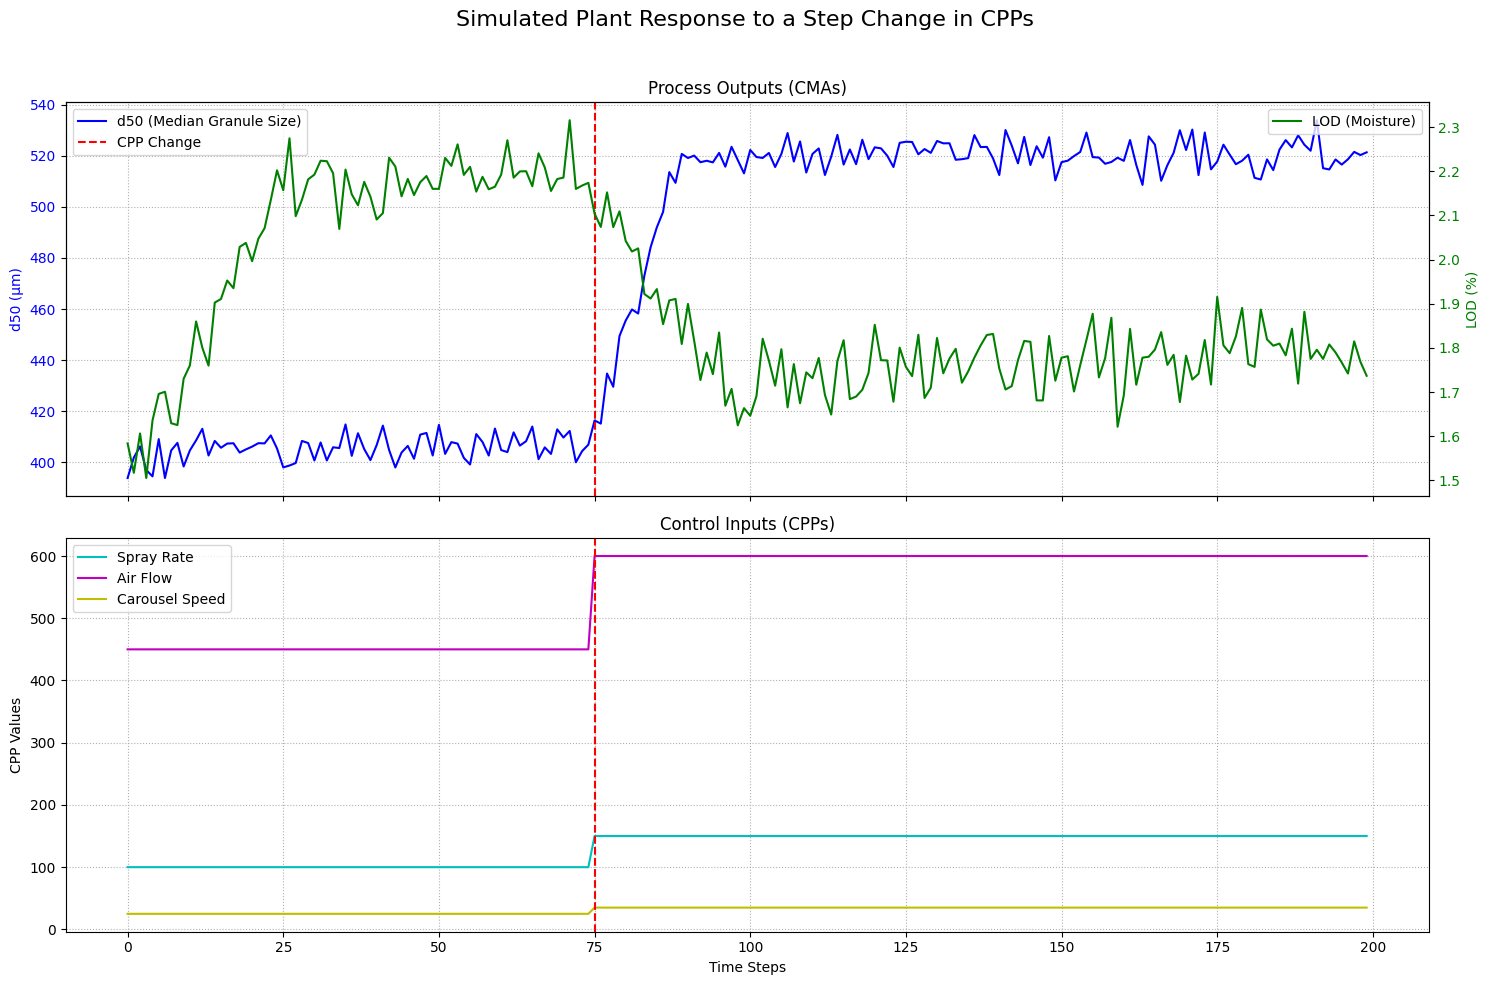

In [4]:
# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Simulated Plant Response to a Step Change in CPPs', fontsize=16)

# Plot 1: Critical Material Attributes (CMAs)
ax1 = axes[0]
ax1.plot(df_history.index, df_history['d50'], label='d50 (Median Granule Size)', color='b')
ax1.set_ylabel('d50 (μm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axvline(x=change_time, color='r', linestyle='--', label='CPP Change')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':')

ax1_twin = ax1.twinx()
ax1_twin.plot(df_history.index, df_history['lod'], label='LOD (Moisture)', color='g')
ax1_twin.set_ylabel('LOD (%)', color='g')
ax1_twin.tick_params(axis='y', labelcolor='g')
ax1_twin.legend(loc='upper right')
ax1.set_title('Process Outputs (CMAs)')

# Plot 2: Critical Process Parameters (CPPs)
ax2 = axes[1]
ax2.plot(df_cpps.index, df_cpps['spray_rate'], label='Spray Rate', color='c')
ax2.plot(df_cpps.index, df_cpps['air_flow'], label='Air Flow', color='m')
ax2.plot(df_cpps.index, df_cpps['carousel_speed'], label='Carousel Speed', color='y')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('CPP Values')
ax2.axvline(x=change_time, color='r', linestyle='--')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle=':')
ax2.set_title('Control Inputs (CPPs)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Analysis of the Results

From the plots, we can observe the key dynamic behaviors we designed:
1.  **Time Lags:** Notice that the `d50` and `LOD` values do not change instantly at `t=75`. It takes several time steps for them to start responding and eventually settle at a new steady state.
2.  **Nonlinear Response:** The magnitude of the change in the CMAs is not directly proportional to the magnitude of the change in the CPPs.
3.  **Interactions:** The final `LOD` value is a result of a complex balance. The increased `air_flow` tries to decrease it, but the increased `carousel_speed` and the now larger `d50` try to increase it.

We now have a sufficiently realistic digital twin. In the next notebook, we will use this simulator to generate the large, rich dataset needed to train our predictive AI model.